In [1]:
!pwd

/


In [2]:
%cd /media/w261-s22-Anand-Patel-95/Assignments/HW2/

/media/w261-s22-Anand-Patel-95/Assignments/HW2


In [3]:
!pwd

/media/w261-s22-Anand-Patel-95/Assignments/HW2


# HW 2 - Naive Bayes in Hadoop MR
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the live sessions for week 2 and week 3 you got some practice designing and debugging Hadoop Streaming jobs. In this homework we'll use Hadoop MapReduce to implement your first parallelized machine learning algorithm: Naive Bayes. As you develop your implementation you'll test it on a small dataset that matches the 'Chinese Example' in the _Manning, Raghavan and Shutze_ reading for Week 2. For the main task in this assignment you'll be working with a small subset of the Enron Spam/Ham Corpus. By the end of this assignment you should be able to:
* __... describe__ the Naive Bayes algorithm including both training and inference.
* __... perform__ EDA on a corpus using Hadoop MR.
* __... implement__ parallelized Naive Bayes.
* __... constrast__ partial, unordered and total order sort and their implementations in Hadoop Streaming.
* __... explain__ how smoothing affects the bias and variance of a Multinomial Naive Bayes model.

As always, your work will be graded both on the correctness of your output and on the clarity and design of your code. __Please refer to the `README` for homework submission instructions.__ 

## Notebook Setup
Before starting, run the following cells to confirm your setup.

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
# global vars (paths) - ADJUST AS NEEDED
JAR_FILE = '/usr/lib/hadoop/hadoop-streaming-3.2.2.jar'
HDFS_DIR = "/user/root/HW2/"
HOME_DIR = "/media/w261-s22-Anand-Patel-95/Assignments/HW2" # FILL IN HERE eg. /media/notebooks/Assignments/HW2

In [6]:
# save path for use in Hadoop jobs (-cmdenv PATH={PATH})
from os import environ
PATH  = environ['PATH']

In [4]:
# Downloading data in DataProc
!mkdir -p data/
!gsutil cp gs://w261-hw-data/main/Assignments/HW2/data/* data/

Copying gs://w261-hw-data/main/Assignments/HW2/data/enronemail_1h.txt...
/ [1 files][199.8 KiB/199.8 KiB]                                                
Operation completed over 1 objects/199.8 KiB.                                    


In [7]:
# data path
ENRON = "data/enronemail_1h.txt"

In [8]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -ls 
!hdfs dfs -mkdir {HDFS_DIR}

Found 1 items
drwxr-xr-x   - root hadoop          0 2022-01-15 18:40 demo2


In [8]:
# check the directory is made
!hdfs dfs -ls

Found 3 items
drwxr-xr-x   - root hadoop          0 2022-01-23 02:44 HW2
drwxr-xr-x   - root hadoop          0 2022-01-15 18:40 demo2
drwxr-xr-x   - root hadoop          0 2022-01-22 01:04 demo3


# Question 1: Hadoop MapReduce Key Takeaways.  

This assignment will be the only one in which you use Hadoop Streaming to implement a distributed algorithm. The key reason we continue to teach Hadoop streaming is because of the way it forces the programmer to think carefully about what is happening under the hood when you parallelize a calculation. This question will briefly highlight some of the most important concepts that you need to understand about Hadoop Streaming and MapReduce before we move on to Spark next week.   

### Q1 Tasks:

* __a) short response:__ What "programming paradigm" is Hadoop MapReduce based on? What are the main ideas of this programming paradigm and how does MapReduce exemplify these ideas?

* __b) short response:__ What is the Hadoop Shuffle? When does it happen? Why is it potentially costly? Describe one specific thing we can we do to mitigate the cost associated with this stage of our Hadoop Streaming jobs.

* __c) short response:__ In Hadoop Streaming why do the input and output record format of a combiner script have to be the same? [__`HINT`__ _what level of combining does the framework guarantee? what is the relationship between the record format your mapper emits and the format your reducer expects to receive?_]

* __d) short response:__ To what extent can you control the level of parallelization of your Hadoop Streaming jobs? Please be specific.

* __e) short response:__ What change in the kind of computing resources available prompted the creation of parallel computation frameworks like Hadoop? 

### Q1 Student Answers:

> __a)__ Hadoop MapReduce is based on the functional programming paradigm. This paradigm emphasizes the evaluation of mathematical functions and avoids changing state and mutable data. It is declarative, so programming is done with expressions. The output of functions depend only on the arguments input into the function, so calling the same function twice with the same arguments will produce the same result each time. A key feature of functional languages is the concept of higher order functions, or functions that can accept other functions as arguments. MapReduce exemplifies this idea because map and reduce are higher-order functions. They are somewhat associated with functional programming’s `Apply All` and `Fold` functions.

> __b)__ Hadoop’s shuffle occurs between the mapping and reducing phase of MapReduce, and it is the most costly part of the MapReduce task. The shuffle involves partitioning records output from the mappers (such that records with the same key end up in the same reducer), sorting records within partitions, and copying data over the network to the right reducers. This operation is costly because the merge-sorting of a large number of records will yield a high time complexity, and the transfer of a large number of records over a network to the reducers will take a lot of time and space. This can be mitigated by **reducing the number of records present in the shuffle** via combiners acting on the outputs of the mapper files or doing in-memory aggregation inside of the mappers.  

> __c)__ The combiners act on the output of the mappers and occur before the input of records into the combiner. The record format for mapper output must match the record format of reducer input, because this is the order of the MapReduce task. Hadoop does not require combiners. Hadoop does not even guarantee that your specified combiner will run, so the input and output of the combiner must always preserve the same record format between the mapper and reducer.

> __d)__ In Hadoop, you can specify what mapper and reducer function to use, and the number of reducers (ex. Setting 2 reducers: ` -numReduceTasks 2 `). We have no control over the number of mappers Hadoop will use (or the number of parallel mapping tasks).  

> __e)__ Hadoop emphasizes running several low-end computers/hardware in parallel to accomplish a task, rather than one very powerful computer. Frameworks like Hadoop were enabled by the easy access to cheap, average/low-end hardware.

# Question 2: MapReduce Design Patterns.  

In the last two live sessions and in your readings from Lin & Dyer you encountered a number of techniques for manipulating the logistics of a MapReduce implementation to ensure that the right information is available at the right time and location. In this question we'll review a few of the key techniques you learned.   

### Q2 Tasks:

* __a) short response:__ What are counters (in the context of Hadoop Streaming)? How are they useful? What kinds of counters does Hadoop provide for you? How do you create your own custom counter?

* __b) short response:__ What are composite keys? How are they useful? How are they related to the idea of custom partitioning?

* __c) short response:__ What is the order inversion pattern? What problem does it help solve? How do we implement it? 

### Q2 Student Answers:

> __a)__ Counters are variables shared between Hadoop’s running instances and incremented or decremented throughout the process such that you get the variable’s total count after your job completes.  These counter variables are just for the programmer, and not available to the mapper/reducer functions.
> 
> Counters are useful for seeing various statistics about your map reduce job and diagnosing issues or potential ways of optimizing your job to run better. 
> Hadoop provides counters for File System Counters, like the number of read/write operations and bytes read/write. There are also Job Counters, which give you the number of map, reduce tasks, time spent mapping, reducing. There are also Map-Reduce framework counters that tell you the number of map input/output records, combiner input/output records, reduce input/output records, number of spilled records and shuffled maps, CPU time spent, memory usage, heap usage, etc. 
>
> From the demo 3 notebook: to use a custom counter you'll just write an appropriately formatted line to the standard error stream. For example the following line would increment a counter called 'counter-name' in group 'MyWordCounters' by 10: `sys.stderr.write("reporter:counter:MyWordCounters,counter-name,10\n")`. Note that the values of your custom counters will be printed to the console in their respective groups just like the built in Job Tracking counters, and counters can only be incremented by integers.
  

> __b)__ Composite keys are when we specify to Hadoop to treat the two fields together as the key for shuffling. Another way to create a composite key would be to simply make a string joining two fields with a comma or dash (anything other than the Hadoop field delimiter). Composite keys are useful for specifying which set of keys are shuffled to the same reducer (partitioning) and for specifying which piece of information in the record to sort by. To do custom partitioning, we tell Hadoop to use all or part of the composite key as a partitioning key. All lines with the same partition key are guaranteed to be processed by the same reducer. (Source: demo3 NB)
  

> __c)__ The order inversion pattern is technique where we use a special character in front of a key, such as `*`, to cause that record to come first in the data stream after sorting and ensure that this record is processed first before all other records in the reducer. This helps us gain access to its value that we need for the reducer do some operation to the records’ values, such as dividing each record’s value by the total count (the special key’s value). Without the order inversion pattern, we would not have access to the total until all the data is passed through and summed.   


# Question 3: Understanding Total Order Sort

The key challenge in distributed computing is to break a problem into a set of sub-problems that can be performed without communicating with each other. Ideally, we should be able to define an arbirtary number of splits and still get the right result, but that is not always possible. Parallelization becomes particularly challenging when we need to make comparisons between records, for example when sorting. Total Order Sort allows us to order large datasets in a way that enables efficient retrieval of results. Before beginning this assignment, make sure you have read and understand the [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb). You can skip the first two MRJob sections, but the rest of section III and all of section IV are **very** important (and apply to Hadoop Streaming) so make sure to read them closely. Feel free to read the Spark sections as well but you won't be responsible for that material until later in the course. To verify your understanding, answer the following questions.

### Q3 Tasks:

* __a) short response:__ What is the difference between a partial sort, an unordered total sort, and a total order sort? From the programmer's perspective, what does total order sort allow us to do that we can't with unordered total? Why is this important with large datasets?

* __b) short response:__ Which phase of a MapReduce job is leveraged to implement Total Order Sort? Which default behaviors must be changed. Why must they be changed?

* __c) short response:__ Describe in words how to configure a Hadoop Streaming job for the custom sorting and partitioning that is required for Total Order Sort.  

* __d) short response:__ Explain why we need to use an inverse hash code function.

* __e) short response:__ Where does this function need to be located so that a Total Order Sort can be performed?

### Q3 Student Answers:

> __a)__ **Partial sort** is when each partition file output from a reducer is sorted within itself only based on the specified key. 
>
> **Unordered total sort** is when all the key-value pairs across all partition files are sorted using the same key, but the order of the partition files are not sorted. 
>
> **Total ordered sort** is when the key-value pairs across all partition files are sorted using the same key, and the partition file names are also assigned in order.

> 
> Total order sort lets us sort key-value pairs across multiple reducers such that we can guarantee that the first partition file contains the top records and the last partition contains the bottom records. The order is preserved throughout all partition files.
>
> This is important with large datasets because without this ordering of key-value pairs across all the partition files, the programmer would need to spend a lot of time looking across all these partition files to find a specific range or set of records. This is equivalent to someone trying to search for a couple words in a dictionary that isn’t alphabetical.
 

> __b)__ Hadoop’s MapReduce job’s default behavior is generating a partial order sort, whereby the reducer’s output will be a lot of partition files each containing key-value records sorted within each partition based on key. This is done by default through an alphanumerical sort on a key within each partition. The shuffle phase of MapReduce is where sorting can be leveraged to implement Total Order Sort. We must change these default behaviors so we can get key-value pairs sorted across all partition files. To perform a total order sort, we need to override the default shuffle behavior by providing a custom partitioner, a custom sort specification (e.g., numeric/alphanumeric increasing/decreasing), and a combiner (optional, for increasing efficiency).

> __c)__ We specify custom sorting and partitioning for a Hadoop Streaming job through `-D` parameters in the command line call to signify changing default behavior. We must specify the number of composite key fields that Hadoop will need to look at. To do custom sorting, we specify a Key Field Based Comparator class and which key(s) to sort on along with the way we want this field’s sorting treated (as a numeric, in reverse, etc.). To do custom partitioning, we specify a key field partitioner class to tell Hadoop that we want to partition the data in a custom way and we specify the custom partitioning keys. 

> __d)__ The inverse hash function is needed to provide Hadoop the key it will use for partitioning the files to produce the Total Order Sort. We want the partition files at the end to be ordered by file name for Total Order Sort. The keys provided by the inverse hash function help Hadoop hash to the correct partition index. Hadoop can now reorder the partition keys so that the partition files are ordered. This will result in the largest values by the sort going to the first partition, and preserving that sorted order going down the partition files. 

> __e)__ It must be located in the mapper function.

# About the Data
For the main task in this portion of the homework you will train a classifier to determine whether an email represents spam or not. You will train your Naive Bayes model on a 100 record subset of the Enron Spam/Ham corpus available in the HW2 data directory (__`HW2/data/enronemail_1h.txt`__).

__Source:__   
The original data included about 93,000 emails which were made public after the company's collapse. There have been a number raw and preprocessed versions of this corpus (including those available [here](http://www.aueb.gr/users/ion/data/enron-spam/index.html) and [here](http://www.aueb.gr/users/ion/publications.html)). The subset we will use is limited to emails from 6 Enron employees and a number of spam sources. It is part of [this data set](http://www.aueb.gr/users/ion/data/enron-spam/) which was created by researchers working on personlized Bayesian spam filters. Their original publication is [available here](http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf). __`IMPORTANT!`__ _For this homework please limit your analysis to the 100 email subset which we provide. No need to download or run your analysis on any of the original datasets, those links are merely provided as context._

__Preprocessing:__  
For their work, Metsis et al. (the authors) appeared to have pre-processed the data, not only collapsing all text to lower-case, but additionally separating "words" by spaces, where "words" unfortunately include punctuation. As a concrete example, the sentence:  
>  `Hey Jon, I hope you don't get lost out there this weekend!`  

... would have been reduced by Metsis et al. to the form:  
> `hey jon , i hope you don ' t get lost out there this weekend !` 

... so we have reverted the data back toward its original state, removing spaces so that our sample sentence would now look like:
> `hey jon, i hope you don't get lost out there this weekend!`  

Thus we have at least preserved contractions and other higher-order lexical forms. However, one must be aware that this reversion is not complete, and that some object (specifically web sites) will be ill-formatted, and that all text is still lower-cased.


__Format:__   
All messages are collated to a tab-delimited format:  

>    `ID \t SPAM \t SUBJECT \t CONTENT \n`  

where:  
>    `ID = string; unique message identifier`  
    `SPAM = binary; with 1 indicating a spam message`  
    `SUBJECT = string; title of the message`  
    `CONTENT = string; content of the message`   
    
Note that either of `SUBJECT` or `CONTENT` may be "NA", and that all tab (\t) and newline (\n) characters have been removed from both of the `SUBJECT` and `CONTENT` columns.  

In [13]:
!pwd

/media/w261-s22-Anand-Patel-95/Assignments/HW2


In [15]:
# take a look at the first 100 characters of the first 5 records (RUN THIS CELL AS IS)
!head -n 5 /media/w261-s22-Anand-Patel-95/Assignments/HW2/{ENRON} | cut -c-100

0001.1999-12-10.farmer	0	 christmas tree farm pictures	NA
0001.1999-12-10.kaminski	0	 re: rankings	 thank you.
0001.2000-01-17.beck	0	 leadership development pilot	" sally:  what timing, ask and you shall receiv
0001.2000-06-06.lokay	0	" key dates and impact of upcoming sap implementation over the next few week
0001.2001-02-07.kitchen	0	 key hr issues going forward	 a) year end reviews-report needs generating 


In [16]:
# see how many messages/lines are in the file 
#(this number may be off by 1 if the last line doesn't end with a newline)
!wc -l /media/w261-s22-Anand-Patel-95/Assignments/HW2/{ENRON}

100 /media/w261-s22-Anand-Patel-95/Assignments/HW2/data/enronemail_1h.txt


In [17]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -mkdir {HDFS_DIR}

mkdir: `/user/root/HW2': File exists


In [18]:
# load the data into HDFS (RUN THIS CELL AS IS)
!hdfs dfs -copyFromLocal /media/w261-s22-Anand-Patel-95/Assignments/HW2/{ENRON} {HDFS_DIR}/enron.txt

In [19]:
!hdfs dfs -ls {HDFS_DIR}

Found 1 items
-rw-r--r--   1 root hadoop     204559 2022-01-18 23:45 /user/root/HW2/enron.txt


# Question 4:  Enron Ham/Spam EDA.
Before building our classifier, lets get aquainted with our data. In particular, we're interested in which words occur more in spam emails than in legitimate ("ham") emails. In this question you'll implement two Hadoop MapReduce jobs to count and sort word occurrences by document class. You'll also learn about two new Hadoop streaming parameters that will allow you to control how the records output from your mappers are partitioned for reducing on separate nodes. 

__`IMPORTANT NOTE:`__ For this question and all subsequent items, you should include both the subject and the body of the email in your analysis (i.e. concatetate them to get the 'text' of the document).

### Q4 Tasks:
* __a) code:__ Complete the missing components of the code in __`EnronEDA/mapper.py`__ and __`EnronEDA/reducer.py`__ to create a Hadoop  MapReduce job that counts how many times each word in the corpus occurs in an email for each class. Pay close attention to the data format specified in the docstrings of these scripts _-- there are a number of ways to accomplish this task, we've chosen this format to help illustrate a technique in `part e`_. Run the provided unit tests to confirm that your code works as expected, then run the provided Hadoop Streaming command to apply your analysis to the Enron data.


* __b) code + short response:__ How many times does the word "__assistance__" occur in each class? (`HINT:` Use a `grep` command to read from the results file you generated in '`a`' and then report the answer in the space provided.)


* __c) short response:__ Would it have been possible to add some sorting parameters to the Hadoop streaming command that would cause our `part a` results to be sorted by count? Explain why or why not. (`HINT:` This question demands an understanding of the sequence of the phases of MapReduce.)


* __d) code + short response:__ Write a second Hadoop MapReduce job to sort the output of `part a` first by class and then by count. Run your job and save the results to a local file. Then describe in words how you would go about printing the top 10 words in each class given this sorted output. (`HINT 1:` _remember that you can simply pass the `part a` output directory to the input field of this job; `HINT 2:` since this task is just reodering the records from `part a` we don't need to write a mapper or reducer, just use `/bin/cat` for both_)


* __e) code:__ A more efficient alternative to '`grep`-ing' for the top 10 words in each class would be to use the Hadoop framework to separate records from each class into its own partition so that we can just read the top lines in each. Rewrite your job from ` part d` to specify 2 reduce tasks and to tell Hadoop to partition based on the second field (which indicates spam/ham in our data). Your code should maintain the secondary sort -- that is each partition should list words from most to least frequent.

### Q4 Student Answers:
> __b)__ The word "assistance" occurs 8 times in spam emails (indicated by class "1") and 2 times in ham emails (indicated by class "0").  

> __c)__ In part A, our total counts are generated at the end of the reduce phase of our Hadoop MapReduce. Sorting happens in the shuffle between mapping and reducing, so it is not possible to add some sorting parameters to this job that cause our results to be sorted by the count because counts are not available until after reducing.

> __d)__ The results of this second Hadoop MapReduce are saved to `EnronEDA/results-d.txt`. The output is sorted first by class (`is_spam` == "0" or "1"), then by the count. Each word will have two lines in the output: one for not spam and one for spam. All the not spam records come first. To print the top 10 words in each of the 2 classes given this output, we can use grep, limit the number of lines to 10, and search for the class parameter PATTERN ("0" or "1") on the line: `grep -m 10 PATTERN [FILE]`. This can cause issues if the PATTERN is also in the count of the word. [Source](https://stackoverflow.com/a/5013198).

In [8]:
# part a - do your work in the provided scripts then RUN THIS CELL AS IS
!chmod a+x EnronEDA/mapper.py
!chmod a+x EnronEDA/reducer.py

In [21]:
# part a - unit test EnronEDA/mapper.py (RUN THIS CELL AS IS)
!echo -e "d1	1	title	body\nd2	0	title	body" | EnronEDA/mapper.py

title	1	1
body	1	1
title	0	1
body	0	1


In [25]:
# part a - unit test EnronEDA/reducer.py (RUN THIS CELL AS IS)
!echo "one	1	1\none	0	1\none	0	1\ntwo	0	1" | EnronEDA/reducer.py

one	1	1
one	0	2
two	1	0
two	0	1


In [26]:
# part a - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

rm: `/user/root/HW2//eda-output': No such file or directory


In [27]:
# part a - Hadoop streaming job (RUN THIS CELL AS IS)
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-3.2.2.jar] /tmp/streamjob7350717178797880771.jar tmpDir=null
2022-01-19 00:56:22,928 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-19 00:56:23,182 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-19 00:56:23,666 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-19 00:56:23,667 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-19 00:56:23,861 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1642548823869_0001
2022-01-19 00:56:24,194 INFO mapred.FileInputFormat: Total input files to process : 1
2022-01-19 00:56:24,271 INFO mapreduce.JobSubmitter: number of splits:9
2022-01-19 00:56:24,416 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1642548823869_0001
2022-01-19 00:56:24,417 INFO mapreduce.

In [28]:
# part a - retrieve results from HDFS & copy them into a local file (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/eda-output/part-0000* > EnronEDA/results.txt

In [29]:
# part b - write your grep command here
!grep assistance EnronEDA/results.txt

assistance	1	8
assistance	0	2


In [30]:
# part d - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

rm: `/user/root/HW2//eda-sort-output': No such file or directory


In [33]:
!hdfs dfs -ls {HDFS_DIR}

Found 2 items
drwxr-xr-x   - root hadoop          0 2022-01-19 00:57 /user/root/HW2/eda-output
-rw-r--r--   1 root hadoop     204559 2022-01-18 23:45 /user/root/HW2/enron.txt


In [34]:
# part d - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2 -k3,3nr" \
  -mapper /bin/cat \
  -reducer /bin/cat \
  -input {HDFS_DIR}/eda-output \
  -output {HDFS_DIR}/eda-sort-output \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-3.2.2.jar] /tmp/streamjob4256408977928831835.jar tmpDir=null
2022-01-19 01:20:58,016 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-19 01:20:58,259 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-19 01:20:58,848 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-19 01:20:58,849 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-19 01:20:59,273 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1642548823869_0002
2022-01-19 01:20:59,587 INFO mapred.FileInputFormat: Total input files to process : 2
2022-01-19 01:20:59,656 INFO mapreduce.JobSubmitter: number of splits:10
2022-01-19 01:20:59,834 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1642548823869_0002
2022-01-19 01:20:59,836 INFO mapreduce

In [36]:
!hdfs dfs -ls "/user/root/HW2/eda-sort-output"

Found 2 items
-rw-r--r--   1 root hadoop          0 2022-01-19 01:21 /user/root/HW2/eda-sort-output/_SUCCESS
-rw-r--r--   1 root hadoop     129303 2022-01-19 01:21 /user/root/HW2/eda-sort-output/part-00000


In [37]:
!hdfs dfs -cat {HDFS_DIR}/eda-sort-output/part-00000* > EnronEDA/results-d.txt

In [38]:
!head EnronEDA/results-d.txt

the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135	


In [68]:
!grep -m 10 "[[:space:]]1[[:space:]]"  EnronEDA/results-d.txt

workout	0	1	
third	0	1	
whom	0	1	
united	0	1	
undercollected	0	1	
usage	0	1	
turn	0	1	
yanowski	0	1	
transporting	0	1	
unique	0	1	


In [69]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

Deleted /user/root/HW2/eda-sort-output


In [70]:
# part e - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k3,3nr" \
  -D mapreduce.partition.keypartitioner.options="-k2,2" \
  -mapper /bin/cat \
  -reducer /bin/cat \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/eda-output \
  -output {HDFS_DIR}/eda-sort-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-3.2.2.jar] /tmp/streamjob4410954524829321680.jar tmpDir=null
2022-01-19 02:05:21,100 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-19 02:05:21,328 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-19 02:05:21,902 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-19 02:05:21,902 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-19 02:05:22,290 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1642548823869_0003
2022-01-19 02:05:22,550 INFO mapred.FileInputFormat: Total input files to process : 2
2022-01-19 02:05:22,610 INFO mapreduce.JobSubmitter: number of splits:10
2022-01-19 02:05:22,764 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1642548823869_0003
2022-01-19 02:05:22,767 INFO mapreduce

In [71]:
# part e - view the top 10 records from each partition (RUN THIS CELL AS IS)
for idx in range(2):
    print(f"\n===== part-0000{idx}=====\n")
    !hdfs dfs -cat {HDFS_DIR}/eda-sort-output/part-0000{idx} | head


===== part-00000=====

the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135	
cat: Unable to write to output stream.

===== part-00001=====

the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153	
cat: Unable to write to output stream.


In [13]:
!hdfs dfs -cat {HDFS_DIR}/eda-sort-output/part-00000 | wc -l

5065


In [28]:
!cat EnronEDA/results.txt | wc -l

10130


__Expected output:__
<table>
<th>part-00000:</th>
<th>part-00001:</th>
<tr><td><pre>
the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135
</pre></td>
<td><pre>
the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153
</pre></td></tr>
</table>

# Question 5: Counters and Combiners.
Tuning the number of mappers & reducers is helpful to optimize very large distributed computations. Doing so successfully requires a thorough understanding of the data size at each stage of the job. As you learned in the week3 live session, counters are an invaluable resource for understanding this kind of detail. In this question, we will take the EDA performed in Question 4 as an opportunity to illustrate some related concepts.

### Q5 Tasks:
* __a) short response:__ Read the Hadoop output from your job in Question 4a to report how many records are emitted by the mappers and how many records are received be the reducers. In the context of word counting what does this number represent practically?

* __b) code:__ Note that we wrote the reducer in question 4a such that the input and output record format is identical. This makes it easy to use the same reducer script as a combiner. In the space provided below, write the Hadoop Streaming command to re-run your job from question 4a with this combining added.

* __c) short response__: Report the number of records emitted by your mappers in part b and the number of records received by your reducers. Compare your results here to what you saw in part a. Explain.

* __d) short response__: Describe a scenario where using a combiner would _NOT_ improve the efficiency of the shuffle stage. Explain. [__`BONUS:`__ how does increasing the number of mappers affect the usefulness of a combiner?]

### Q5 Student Answers:
> __a)__ In question 4a, the number of records emitted by the mappers is `Map output records=31490` and the number of records received by the reducers is the same: `Reduce input records=31490`. Since the mapper is emitting "word \t class \t 1", this number is the total number of words in the data.    

> __c)__ In 5b, the mappers emitted 31490 records, just as it did in 4a, but the reducers now receive 20576 records, less than our 31490 from 4a, because the combiner aggregated some records by key and reduced the number of records coming out of the mapper.

> __d)__ If every mapper node's data has unique keys only, the combiner would not have any records to group together by key and would not reduce the number of records emitted by the mapper. This would not improve the efficiency of the shuffle stage since there would be no reduction in the number of records.

In [72]:
# part b - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

Deleted /user/root/HW2/eda-output


In [73]:
# part b - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -combiner reducer.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-3.2.2.jar] /tmp/streamjob5209350383389511199.jar tmpDir=null
2022-01-19 03:40:43,537 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-19 03:40:43,801 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-19 03:40:44,269 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-19 03:40:44,270 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-19 03:40:44,460 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1642548823869_0004
2022-01-19 03:40:45,154 INFO mapred.FileInputFormat: Total input files to process : 1
2022-01-19 03:40:45,604 INFO mapreduce.JobSubmitter: number of splits:9
2022-01-19 03:40:45,754 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1642548823869_0004
2022-01-19 03:40:45,755 INFO mapreduce.

# Question 6: Document Classification Task Overview.
The week 2 assigned reading from Chapter 13 of _Introduction to Information Retrieval_ by Manning, Raghavan and Schutze provides a thorough introduction to the document classification task and the math behind Naive Bayes. In this question we'll use the example from Table 13.1 (reproduced below) to 'train' an unsmoothed Multinomial Naive Bayes model and classify a test document by hand.

<table>
<th>DocID</th>
<th>Class</th>
<th>Subject</th>
<th>Body</th>
<tr><td>Doc1</td><td>1</td><td></td><td>Chinese Beijing Chinese</td></tr>
<tr><td>Doc2</td><td>1</td><td></td><td>Chinese Chinese Shanghai</td></tr>
<tr><td>Doc3</td><td>1</td><td></td><td>Chinese Macao</td></tr>
<tr><td>Doc4</td><td>0</td><td></td><td>Tokyo Japan Chinese</td></tr>
</table>

### Q6 Tasks:
* __a) short response:__ Equation 13.3 in Manning, Raghavan and Shutze shows how a Multinomial Naive Bayes model classifies a document. It predicts the class, $c$, for which the estimated conditional probability of the class given the document's contents,  $\hat{P}(c|d)$, is greatest. In this equation what two pieces of information are required to calculate  $\hat{P}(c|d)$? Your answer should include both mathematical notatation and verbal explanation.


* __b) short response:__ The Enron data includes two classes of documents: `spam` and `ham` (they're actually labeled `1` and `0`). In plain English, explain what  $\hat{P}(c)$ and   $\hat{P}(t_{k} | c)$ mean in the context of this data. How will we would estimate these values from a training corpus? How many passes over the data would we need to make to retrieve this information for all classes and all words?


* __c) hand calculations:__ Above we've reproduced the document classification example from the textbook (we added an empty subject field to mimic the Enron data format). Remember that the classes in this "Chinese Example" are `1` (about China) and `0` (not about China). Calculate the class priors and the conditional probabilities for an __unsmoothed__ Multinomial Naive Bayes model trained on this data. Show the calculations that lead to your result using markdown and $\LaTeX$ in the space provided or by embedding an image of your hand written work. [`NOTE:` _Your results should NOT match those in the text -- they are training a model with +1 smoothing you are training a model without smoothing_]


* __d) hand calculations:__ Use the model you trained to classify the following test document: `Chinese Chinese Chinese Tokyo Japan`. Show the calculations that lead to your result using markdown and   $\LaTeX$ in the space provided or by embedding an image of your hand written work.


* __e) short response:__ Compare the classification you get from this unsmoothed model in `d`/`e` to the results in the textbook's "Example 1" which reflects a model with Laplace plus 1 smoothing. How does smoothing affect our inference?

### Q6 Student Answers:
> __a)__ In order to compute the conditional probability of a class given the document $\hat{P}(c|d)$, we need  $\hat{P}(c)$, the prior probability of class $c$, and $\hat{P}(t_{k} | c)$, the conditional probability of each of document $d$'s words $t$ given this class $c$.

> __b)__ $\hat{P}(c)$ gives the probability of a document being in the `spam` `1` class or `ham` `0` class. This is estimated from the training corpus by dividing the number of documents belonging in each of these classes by the total number of documents in the training corpus: $\hat{P}(c) = \frac{N_c}{N}$. $\hat{P}(t_{k} | c)$ are the relative frequencies of each word in documents classified by `spam` or `ham`. We estimate the relative frequency of term $t$ in documents belonging to class $c$ as follows: count the number of occurences of $t$ in training documents of class $c$ and divide by the total number of words in documents of class $c$. To retrieve this information for all classes and all words, we need to pass over the data one time.

> __c)__ See below.

> __d)__ See below. We determine that this sentense is **Not About China**.

> __e)__ We end up classifying this document as Not About China `C=0`, while the textbook classify it as about China `C=1`. This is because our unsmoothed model has 0's for the conditional probabilities of words from our vocabulary that do not appear in a given class `C`. In our test case it was 0 for $\hat{P}(t = Japan | c = 1)$ and $\hat{P}(t = Tokyo | c = 1)$. When we computed the probability of this sentence being About China, these 0 probabilities were multiplied in Eqn 13.4 and produced a 0 probability overall of this document being in class About China `c = 1`.


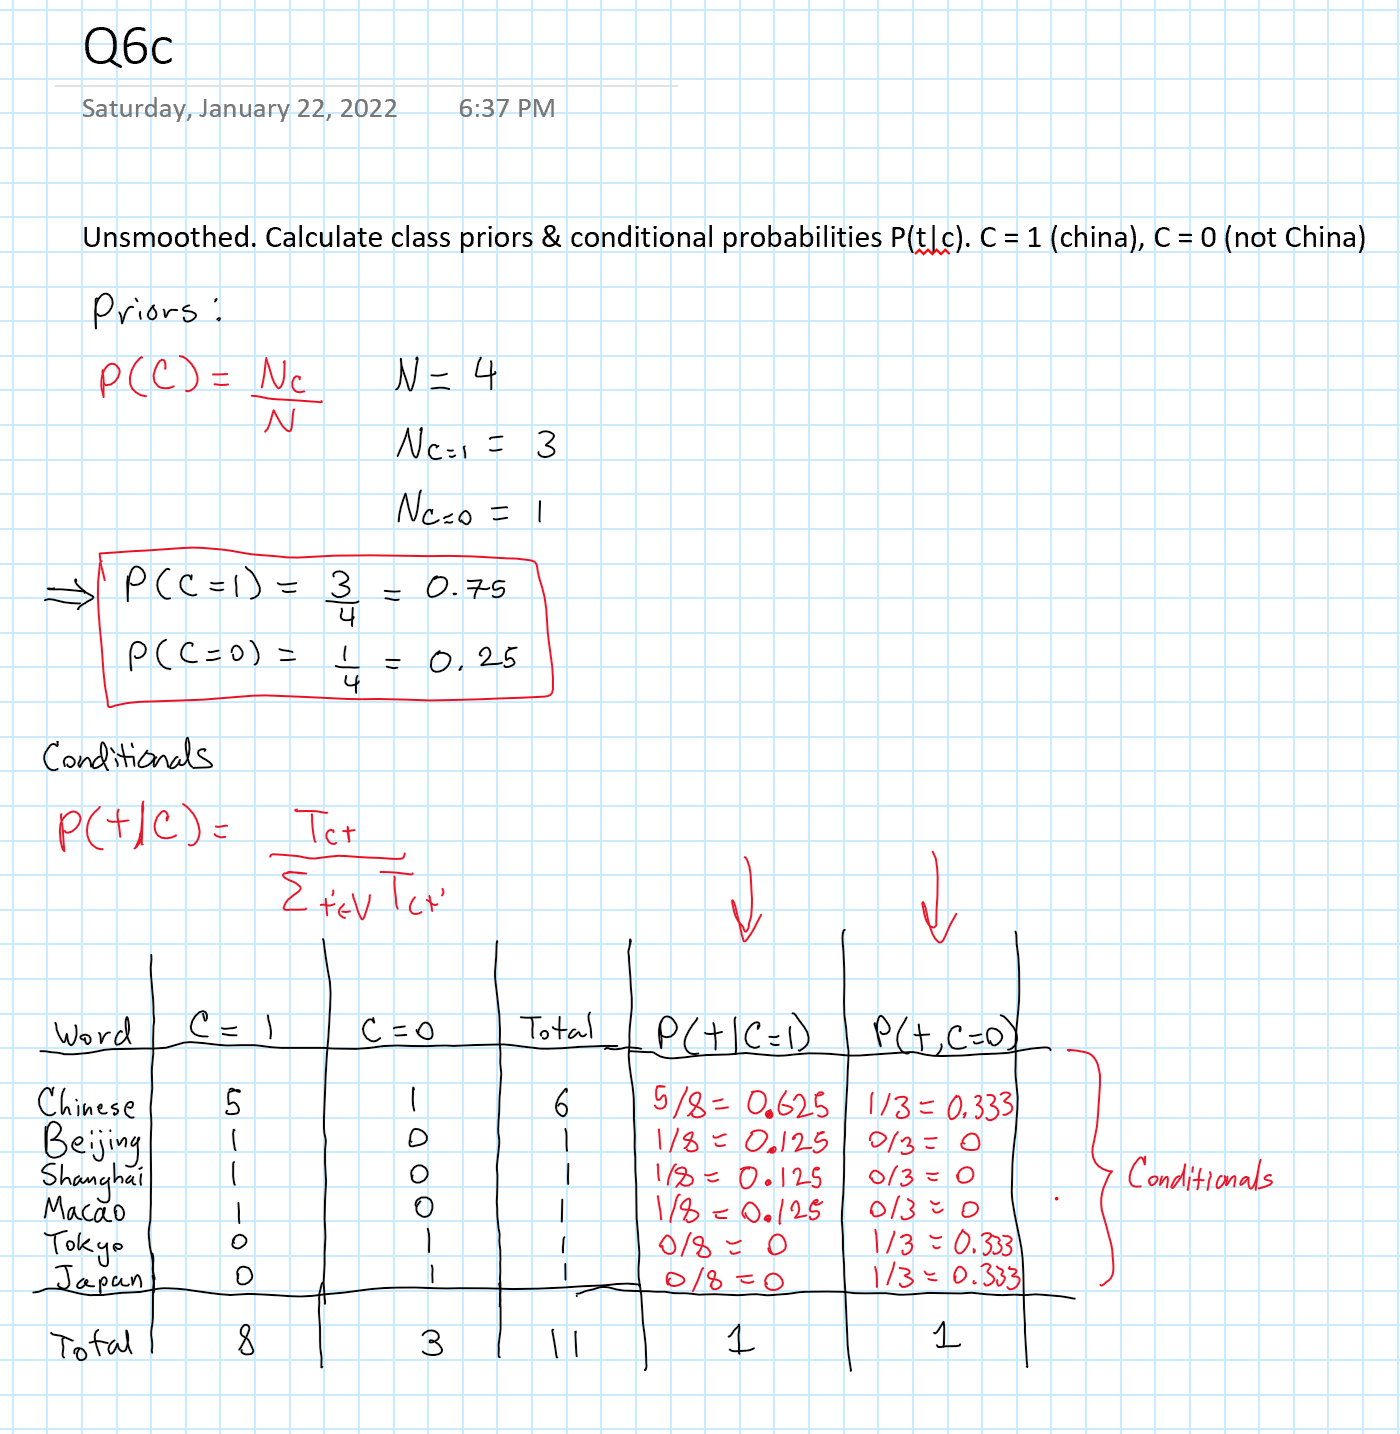

In [9]:
# part d/e - if you didn't write out your calcuations above, embed a picture of them here:
from IPython.display import Image
Image(filename="6c.png")

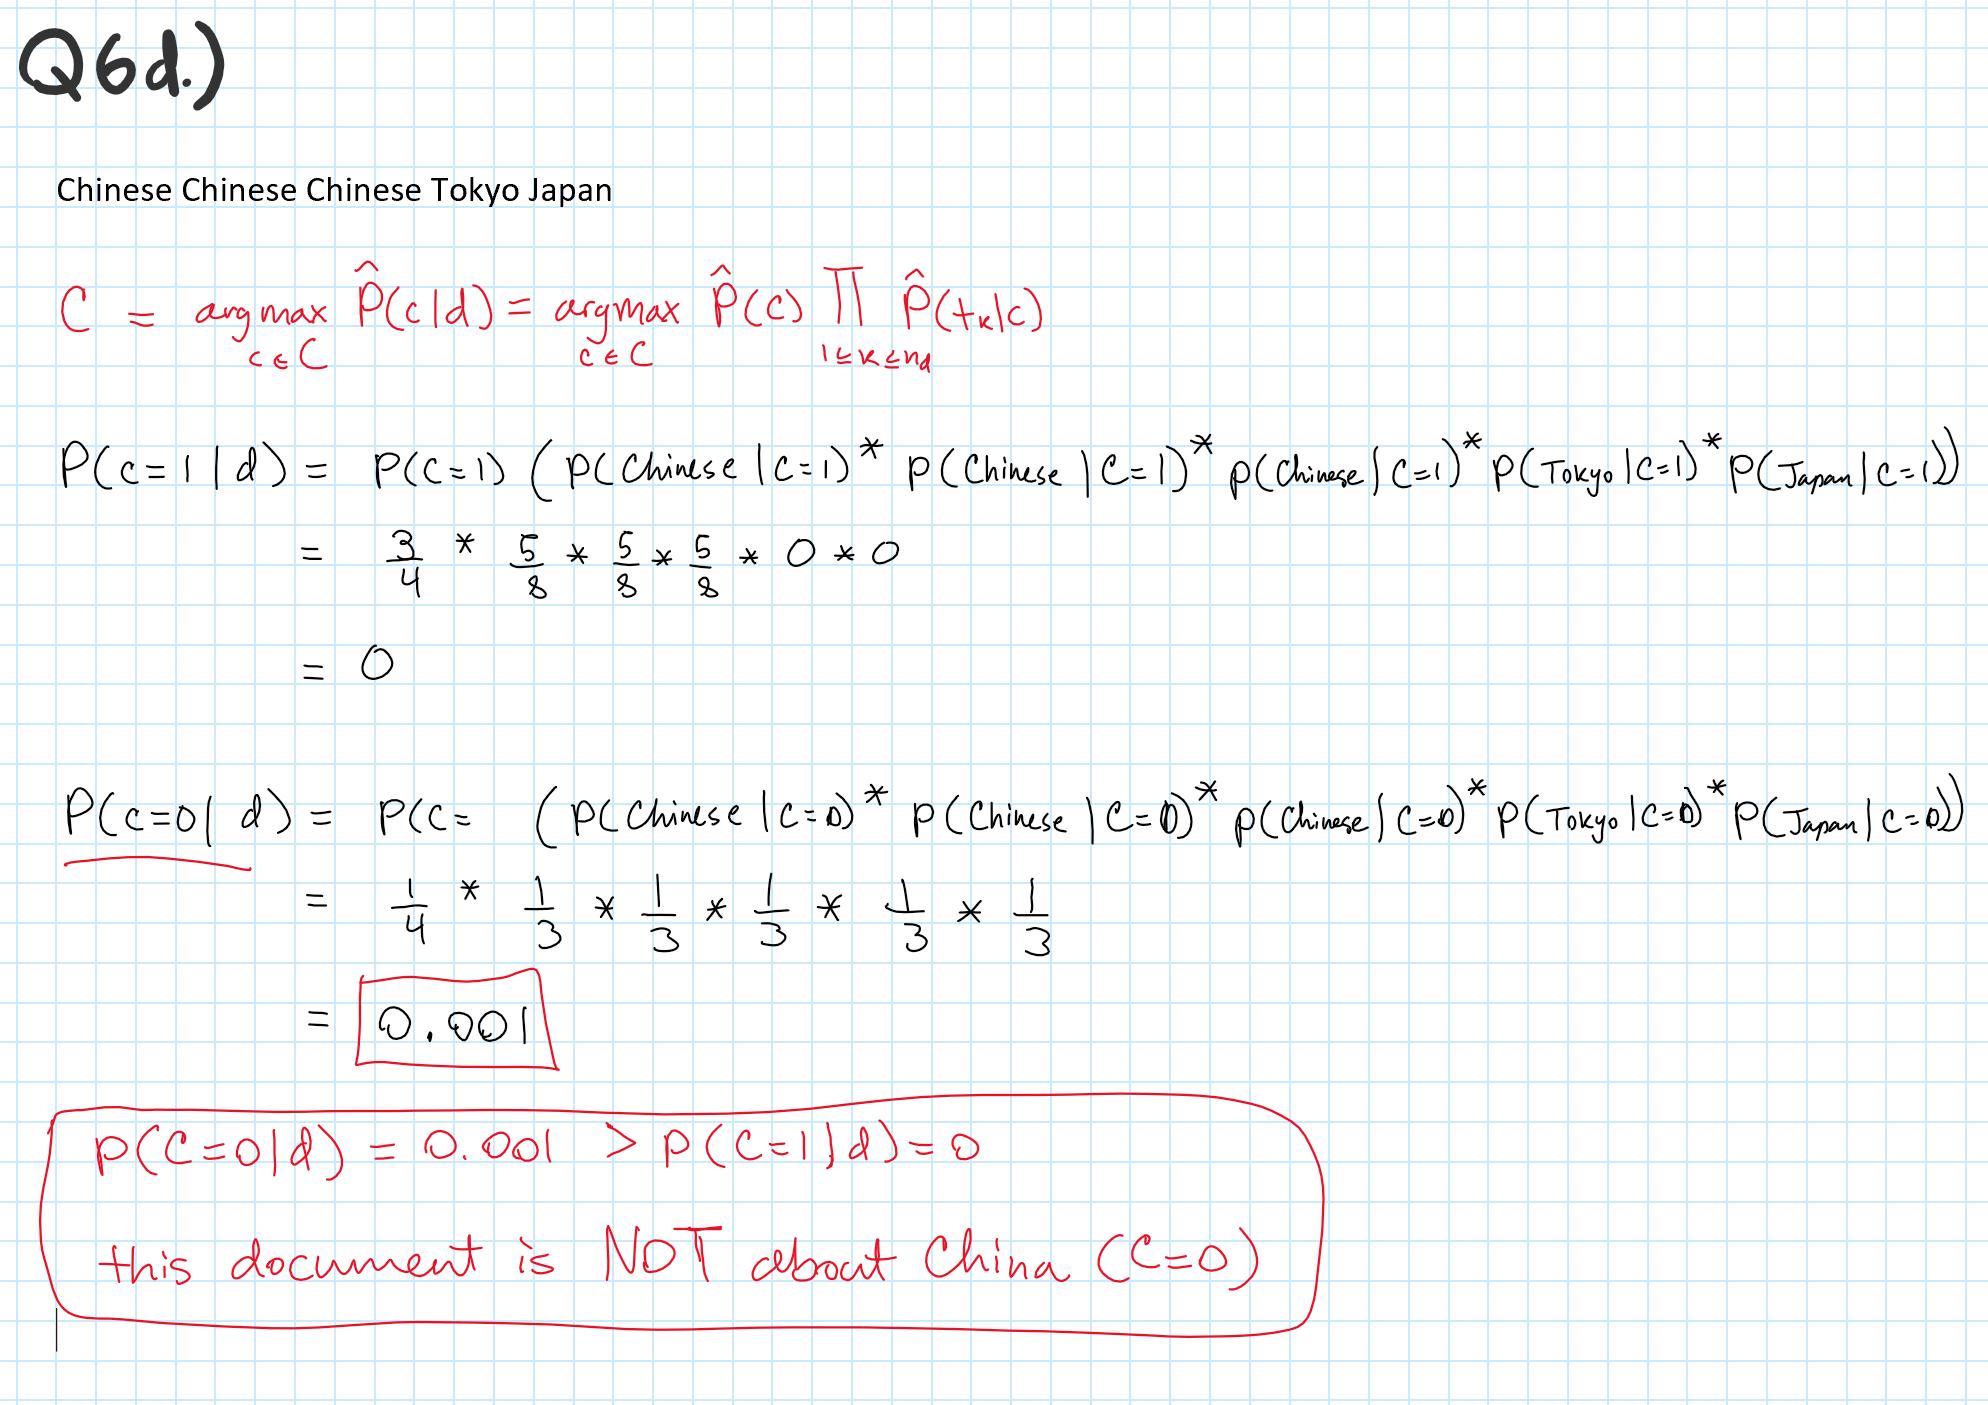

In [10]:
# part d/e - if you didn't write out your calcuations above, embed a picture of them here:
Image(filename="6d.png")

# Question 7: Naive Bayes Inference.
In the next two questions you'll write code to parallelize the Naive Bayes calculations that you performed above. We'll do this in two phases: one MapReduce job to perform training and a second MapReduce to perform inference. While in practice we'd need to train a model before we can use it to classify documents, for learning purposes we're going to develop our code in the opposite order. By first focusing on the pieces of information/format we need to perform the classification (inference) task you should find it easier to develop a solid implementation for training phase when you get to question 8 below. In both of these questions we'll continue to use the Chinese example corpus from the textbook to help us test our MapReduce code as we develop it. Below we've reproduced the corpus, test set and model in text format that matches the Enron data.

### Q7 Tasks:
* __a) short response:__ run the provided cells to create the example files and load them in to HDFS. Then take a closer look at __`NBmodel.txt`__. This text file represents a Naive Bayes model trained (with Laplace +1 smoothing) on the example corpus. What are the 'keys' and 'values' in this file? Which record means something slightly different than the rest? The value field of each record includes two numbers which will be helpful for debugging but which we don't actually need to perform inference -- what are they? [`HINT`: _This file represents the model from Example 13.1 in the textbook, if you're having trouble getting oriented try comparing our file to the numbers in that example._]


* __b) short response:__ When performing Naive Bayes in practice instead of multiplying the probabilities (as in equation 13.3) we add their logs (as in equation 13.4). Why do we choose to work with log probabilities? If we had an unsmoothed model, what potential error could arise from this transformation?


* __c) short response:__ Documents 6 and 8 in the test set include a word that did not appear in the training corpus (and as a result does not appear in the model). What should we do at inference time when we need a class conditional probability for this word?


* __d) short response:__ The goal of our MapReduce job is to stream over the test set and classify each document by peforming the calculation from equation 13.4. To do this we'll load the model file (which contains the probabilities for equation 13.4) into memory on the nodes where we do our mapping. This is called an in-memory join. Does loading a model 'state' like this depart from the functional programming principles? Explain why or why not. From a scability perspective when would this kind of memory use be justified? when would it be unwise?


* __e) code:__ Complete the code in __`NaiveBayes/classify_mapper.py`__. Read the docstring carefully to understand how this script should work and the format it should return. Run the provided unit tests to confirm that your script works as expected then write a Hadoop streaming job to classify the Chinese example test set. [`HINT 1:` _you shouldn't need a reducer for this one._ `HINT 2:` _Don't forget to add the model file to the_ `-files` _parameter in your Hadoop streaming job so that it gets shipped to the mapper nodes where it will be accessed by your script._]


* __f) short response:__ In our test example and in the Enron data set we have fairly short documents. Since these fit fine in memory on a mapper node we didn't need a reducer and could just do all of our calculations in the mapper. However with much longer documents (eg. books) we might want a higher level of parallelization -- for example we might want to process parts of a document on different nodes. In this hypothetical scenario how would our algorithm design change? What could the mappers still do? What key-value structure would they emit? What would the reducers have to do as a last step?

### Q7 Student Answers:
> __a)__ The keys are the words in the training corpus (ex. beijing, chinese, etc.). The 4 values in the file are: the count in class 0, count in class 1, conditional probability of a word in class 0, conditional probability of the word in class 1. The last two fields, conditional probabilities of the word given the document is not about China `c = 0` and the document is about China `c = 1` respectively, are all we need for Naive Bayes calculation and the two counts per class will be helpful for debugging. The record with key `ClassPriors` is the special record. It gives the counts of the total number of documents in class 0, total number of documents in class 1, the prior of class 0, and the prior of class 1.

> __b)__ Taking log probabilities helps us avoid floating point errors when we multiply many many decimals with each other to make smaller numbers, since we can equivalently sum the log probabilities to determine the predicted class. We need to be careful when taking log probabilities in unsmoothed models because there exist conditional probabilities of 0 when a word does not appear in a class. Taking the $log(0)$ is undefined and produces an error.

> __c)__ We can ignore this word and getting a conditional probability for it when we are computing the probablities of each class. Only use the conditional probabilities of words in the test set that appeared in our training corpus.

> __d)__ This does depart from the functional programming paradigm of being stateless since we are storing the model's state in memory. However, none of the mappers are updating the model once it is loaded into memory. If our model is small due to a small vocabulary, then it is justified to use memory this way. If the vocabulary and model are too large to fit into memory, then we should avoid this way of loading the model since we do not want to crash our implementation for large scale data.

> __e)__ Complete the coding portion of this question before answering 'f'.

> __f)__ If we want to process parts of a document in different mapper nodes, then we would need our mappers to still emit the word and conditional log probabilities of every word they encounter in their sub-documents as a single record (ex. `word \t logpHam \t logpSpam`). This lets each mapper emit the log probabilities of parts of the documents they process, without any overlap or double counting. You could even do combining on these emitted log probability records. The reducer would need to sum up the conditional log probabilities of all the words for ham and spam, then add the ClassPriors for ham and spam to the respective sum conditional probabilities. The final prediction comes from picking which class's sum is higher.


Run these cells to create the example corpus and model.

In [11]:
%%writefile NaiveBayes/chineseTrain.txt
D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese

Writing NaiveBayes/chineseTrain.txt


In [12]:
%%writefile NaiveBayes/chineseTest.txt
D5	1		Chinese Chinese Chinese Tokyo Japan
D6	1		Beijing Shanghai Trade
D7	0		Japan Macao Tokyo
D8	0		Tokyo Japan Trade

Writing NaiveBayes/chineseTest.txt


In [13]:
%%writefile NBmodel.txt
beijing	0.0,1.0,0.111111111111,0.142857142857
chinese	1.0,5.0,0.222222222222,0.428571428571
tokyo	1.0,0.0,0.222222222222,0.0714285714286
shanghai	0.0,1.0,0.111111111111,0.142857142857
ClassPriors	1.0,3.0,0.25,0.75
japan	1.0,0.0,0.222222222222,0.0714285714286
macao	0.0,1.0,0.111111111111,0.142857142857

Writing NBmodel.txt


In [14]:
# load the data files into HDFS
!hdfs dfs -copyFromLocal NaiveBayes/chineseTrain.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal NaiveBayes/chineseTest.txt {HDFS_DIR}

Your work for `part e` starts here:

In [9]:
# part e - do your work in NaiveBayes/classify_mapper.py first, then run this cell.
!chmod a+x NaiveBayes/classify_mapper.py

In [27]:
!cat NaiveBayes/classify_mapper.py

#!/usr/bin/env python
"""
Mapper for Naive Bayes Inference.
INPUT:
    ID \t true_class \t subject \t body \n
OUTPUT:
    ID \t true_class \t logP(ham|doc) \t logP(spam|doc) \t predicted_class
SUPPLEMENTAL FILE: 
    This script requires a trained Naive Bayes model stored 
    as NBmodel.txt in the current directory. The model should 
    be a tab separated file whose records look like:
        WORD \t ham_count,spam_count,P(word|ham),P(word|spam)
        
Instructions:
    We have loaded the supplemental file and taken the log of 
    each conditional probability in the model. We also provide
    the code to tokenize the input lines for you. Keep in mind 
    that each 'line' of this file represents a unique document 
    that we wish to classify. Fill in the missing code to get
    the probability of each class given the words in the document.
    Remember that you will need to handle the case where you
    encounter a word that is not represented in the model.
"""
import os
import r

In [25]:
# part e - unit test NaiveBayes/classify_mapper.py (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | column -t

d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737812  0
d8  0  -4.394449154674438  -5.565796731681498  0


In [26]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/chinese-output

rm: `/user/root/HW2//chinese-output': No such file or directory


In [27]:
# part e - write your Hadooop streaming job here
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer /bin/cat \
  -input {HDFS_DIR}/chineseTest.txt \
  -output {HDFS_DIR}/chinese-output \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-3.2.2.jar] /tmp/streamjob8905967995206089821.jar tmpDir=null
2022-01-23 02:44:28,539 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-23 02:44:28,794 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-23 02:44:29,283 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-23 02:44:29,284 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-23 02:44:29,479 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1642898147368_0001
2022-01-23 02:44:29,869 INFO mapred.FileInputFormat: Total input files to process : 1
2022-01-23 02:44:30,359 INFO mapreduce.JobSubmitter: number of splits:10
2022-01-23 02:44:30,508 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1642898147368_0001
2022-01-23 02:44:30,510 INFO mapreduce

In [28]:
# part e - retrieve test set results from HDFS (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/chinese-output/part-000* > NaiveBayes/chineseResults.txt

In [29]:
# part e - take a look (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseResults.txt | column -t

d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737812  0
d8  0  -4.394449154674438  -5.565796731681498  0


<table>
<th> Expected output for the test set:</th>
<tr align=Left><td><pre>
d5	1	-8.90668134	-8.10769031	1
d6	1	-5.78074351	-4.17950237	1
d7	0	-6.59167373	-7.51170688	0
d8	0	-4.39444915	-5.56579673	0
</pre></td><tr>
</table>

# Question 8: Naive Bayes Training.
In Question 7 we used a model that we had trained by hand. Next we'll develop the code to do that same training in parallel, making it suitable for use with larger corpora (like the Enron emails). The end result of the MapReduce job you write in this question should be a model text file that looks just like the example (`NBmodel.txt`) that we created by hand above.

To refresh your memory about the training process take a look at  `6a` and `6b` where you described the pieces of information you'll need to collect in order to encode a Multinomial Naive Bayes model. We now want to retrieve those pieces of information while streaming over a corpus. The bulk of the task will be very similar to the word counting excercises you've already done but you may want to consider a slightly different key-value record structure to efficiently tally counts for each class. 

The most challenging (interesting?) design question will be how to retrieve the totals (# of documents and # of words in documents for each class). Of course, counting these numbers is easy. The hard part is the timing: you'll need to make sure you have the counts totalled up _before_ you start estimating the class conditional probabilities for each word. It would be best (i.e. most scalable) if we could find a way to do this tallying without storing the whole vocabulary in memory... Use an appropriate MapReduce design pattern to implement this efficiently! 


### Q8 Tasks:
* __a) make a plan:__  Fill in the docstrings for __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ to appropriately reflect the format that each script will input/output. [`HINT:` _the input files_ (`enronemail_1h.txt` & `chineseTrain.txt`) _have a prespecified format and your output file should match_ `NBmodel.txt` _so you really only have to decide on an internal format for Hadoop_].


* __b) implement it:__ Complete the code in __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ so that together they train a Multinomial Naive Bayes model __with no smoothing__. Make sure your end result is formatted correctly (see note above). Test your scripts independently and together (using `chineseTrain.txt` or test input of your own devising). When you are satisfied with your Python code design and run a Hadoop streaming command to run your job in parallel on the __chineseTrain.txt__. Confirm that your trained model matches your hand calculations from Question 6.


* __c) short response:__ We saw in Question 6 that adding Laplace smoothing (where the smoothing parameter $k=1$) makes our classifications less sensitve to rare words. However implementing this technique requires access to one additional piece of information that we had not previously used in our Naive Bayes training. What is that extra piece of information? [`HINT:` see equation 13.7 in Manning, Raghavan and Schutze].


* __d) short response:__ There are a couple of approaches that we could take to handle the extra piece of information you identified in `c`: 1) if we knew this extra information beforehand, we could provide it to our reducer as a configurable parameter for the vocab size dynamically (_where would we get it in the first place?_). Or 2) we could compute it in the reducer without storing any bulky information in memory but then we'd need some postprocessing or a second MapReduce job to complete the calculation (_why?_). Breifly explain what is non-ideal about each of these options. 


* __e) code + short response:__ Choose one of the 2 options above. State your choice & reasoning in the space below then use that strategy to complete the code in __`NaiveBayes/train_reducer_smooth.py`__. Test this alternate reducer then write and run a Hadoop streaming job to train an MNB model with smoothing on the Chinese example. Your results should match the model that we provided for you above (and the calculations in the textbook example). __IMPORTANT NOTE:__ For full credit on this question, your code must work with multiple reducers. 

    - [`HINT:` You will need to implement custom partitioning - [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb)] 

    - [`HINT:` Don't start from scratch with this one -- you can just copy over your reducer code from part `b` and make the needed modifications]. 



__IMPORTANT NOTE:__ For full credit on this question, your code must work with multiple reducers. [`HINT:`_You will need to implement custom partitioning - [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb)]


### Q8 Student Answers:
> __c)__  We need the vocabulary size to calculate the conditional probabilities of each term `P(t|c)`. We add this term to the number of words in the class in the denominator.

> __d)__  Option 1 means that we need the vocabulary size from some pre-analysis or EDA (like we did in Q4). We can send this value to our Hadoop Streaming job as an environmental variable, which can be used in the mapper or reducer. Option 2 means that we would need to run post processing or a second MapReduce job to calculate the conditional probabilities. This is because computing the unique vocabulary size in the reducer requires a pass through the data to tally up the unique words encountered. Calculating the conditional probabilities requires this vocabulary size right from the beginning, but this implmentation only makes it available at the end of the reduce job. Therefore, we would need to store the counts of each word, and post-process Eqn 13.7 using the computed vocabulary size.

> __e)__ I choose option 1 because I already have the size of the vocabulary for the Chinese words (6, it is easy to hand count), and I already have the size of the vocabulary for the entire ENRON dataset from the EDA in Q4: the number of lines in `results.txt` divided by 2 (since each word has a record for the 2 classes). Option 2 requires a second streaming job or post-processing, which is not needed if the values are available. I will hard code the vocabulary size for the chinese dataset, and pass in the vocab size of the ENRON training data as an environment variable if needed later on. 


In [34]:
# Using EDA from part 4a to find the vocabulary size...

# results.txt has 2 lines per unique word in input file.
# half of line numbers is the ENRON total vocabulary size
!cat EnronEDA/results.txt | wc -l | awk '{print $1/2}'

5065


In [10]:
# part a - do your work in train_mapper.py and train_reducer.py then RUN THIS CELL AS IS
!chmod a+x NaiveBayes/train_mapper.py
!chmod a+x NaiveBayes/train_reducer.py
!echo "=========== MAPPER DOCSTRING ============"
!head -n 8 NaiveBayes/train_mapper.py | tail -n 6
!echo "=========== REDUCER DOCSTRING ============"
!head -n 8 NaiveBayes/train_reducer.py | tail -n 6

=========== MAPPER DOCSTRING ============
Mapper reads in text documents and emits word counts by class.
INPUT:                                                    
    DocID \t true_class \t subject \t body                
OUTPUT:                                                   
    partitionKey \t word \t class0_partialCount,class1_partialCount       
    
=========== REDUCER DOCSTRING ============
Reducer aggregates word counts by class and emits frequencies.

INPUT:
    partitionKey \t word \t class0_partialCount,class1_partialCount
OUTPUT:
    word \t ham_count,spam_count,P(ham|word),P(spam|word)


In [28]:
!cat NaiveBayes/train_mapper.py

#!/usr/bin/env python
"""
Mapper reads in text documents and emits word counts by class.
INPUT:                                                    
    DocID \t true_class \t subject \t body                
OUTPUT:                                                   
    partitionKey \t word \t class0_partialCount,class1_partialCount       
    

Instructions:
    You know what this script should do, go for it!
    (As a favor to the graders, please comment your code clearly!)
    
    A few reminders:
    1) To make sure your results match ours please be sure
       to use the same tokenizing that we have provided in
       all the other jobs:
         words = re.findall(r'[a-z]+', text-to-tokenize.lower())
         
    2) Don't forget to handle the various "totals" that you need
       for your conditional probabilities and class priors.
       
Partitioning:
    In order to send the totals to each reducer, we need to implement
    a custom partitioning strategy.
    
    We will gene

In [29]:
!cat NaiveBayes/train_reducer.py

#!/usr/bin/env python
"""
Reducer aggregates word counts by class and emits frequencies.

INPUT:
    partitionKey \t word \t class0_partialCount,class1_partialCount
OUTPUT:
    word \t ham_count,spam_count,P(ham|word),P(spam|word)
    
Instructions:
    Again, you are free to design a solution however you see 
    fit as long as your final model meets our required format
    for the inference job we designed in Question 8. Please
    comment your code clearly and concisely.
    
    A few reminders: 
    1) Don't forget to emit Class Priors (with the right key).
    2) In python2: 3/4 = 0 and 3/float(4) = 0.75
"""
##################### YOUR CODE HERE ####################
import sys
import numpy as np

# initialize counts
# ham, spam docs
docTotalCount = np.array([0.0,0.0])
# ham, spam words
wordTotalCount = np.array([0.0,0.0])
current_word = None
current_counts = np.array([0.0,0.0])

# read in records
for line in sys.stdin:
    pk, word, count_bundle = line.split('\t')           # unpa

In [30]:
!cat NaiveBayes/train_reducer_smooth.py

#!/usr/bin/env python

import os
import sys                                                  
import numpy as np  

#################### YOUR CODE HERE ###################

# get the vocabulary size from environment variables
# total ENRON = 5065, Chinese dataset = 6, ENRON training = 4555
V = int(os.getenv('VOCAB', default=6)) # default to chinese dataset size if nothing is specified

# get the smoothing parameter, default is +1
k = int(os.getenv('SMOOTH', default=1))

# initialize counts
# ham, spam docs
docTotalCount = np.array([0.0,0.0])
# ham, spam words
wordTotalCount = np.array([0.0,0.0])
current_word = None
current_counts = np.array([0.0,0.0])

# read in records
for line in sys.stdin:
    pk, word, count_bundle = line.split('\t')           # unpack the line
    counts = [int(n) for n in count_bundle.split(',')]  # unpack the counts class0_partialCount,class1_partialCount
    
    # check for special keys
    if word == "*docTotalCount":
        docTotalCount += counts
    elif 

__`part b starts here`:__ MNB _without_ Smoothing (training on Chinese Example Corpus).

In [42]:
# part b - write a unit test for your mapper here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py

A	chinese	0,1
A	beijing	0,1
A	chinese	0,1
A	chinese	0,1
A	chinese	0,1
A	shanghai	0,1
A	chinese	0,1
A	macao	0,1
A	tokyo	1,0
A	japan	1,0
A	chinese	1,0
A	*docTotalCount	1,3
A	*wordTotalCount	3,8


In [61]:
# part b - write a unit test for your reducer here
# save mapper to output file
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k2,2 > mapper_output_tmp_q7c.txt
!cat mapper_output_tmp_q7c.txt | NaiveBayes/train_reducer.py | column -t

beijing      0,1,0.0,0.125
chinese      1,5,0.3333333333333333,0.625
japan        1,0,0.3333333333333333,0.0
macao        0,1,0.0,0.125
shanghai     0,1,0.0,0.125
tokyo        1,0,0.3333333333333333,0.0
ClassPriors  1.0,3.0,0.25,0.75


In [59]:
# part b - write a systems test for your mapper + reducer together here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k2,2 | NaiveBayes/train_reducer.py | column -t

beijing      0,1,0.0,0.125
chinese      1,5,0.3333333333333333,0.625
japan        1,0,0.3333333333333333,0.0
macao        0,1,0.0,0.125
shanghai     0,1,0.0,0.125
tokyo        1,0,0.3333333333333333,0.0
ClassPriors  1.0,3.0,0.25,0.75


In [58]:
# part b - clear (and name) an output directory in HDFS for your unsmoothed chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/chinese-train-output-unsmoothed

rm: `/user/root/HW2//chinese-train-output-unsmoothed': No such file or directory


In [62]:
# part b - write your hadoop streaming job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=2 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer.py \
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/chinese-train-output-unsmoothed \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-3.2.2.jar] /tmp/streamjob656954109851507395.jar tmpDir=null
2022-01-23 23:45:43,380 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-23 23:45:43,634 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-23 23:45:44,166 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-23 23:45:44,167 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-23 23:45:44,349 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1642957330112_0002
2022-01-23 23:45:45,110 INFO mapred.FileInputFormat: Total input files to process : 1
2022-01-23 23:45:45,169 INFO mapreduce.JobSubmitter: number of splits:10
2022-01-23 23:45:45,309 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1642957330112_0002
2022-01-23 23:45:45,311 INFO mapreduce.

In [63]:
# part b - extract your results (i.e. model) to a local file
!hdfs dfs -cat {HDFS_DIR}/chinese-train-output-unsmoothed/part-0000* > NaiveBayes/chinese_model_unsmoothed_results.txt

In [64]:
# part b - print your model so that we can confirm that it matches expected results
!cat NaiveBayes/chinese_model_unsmoothed_results.txt | column -t

beijing      0,1,0.0,0.125
japan        1,0,0.3333333333333333,0.0
tokyo        1,0,0.3333333333333333,0.0
ClassPriors  1.0,3.0,0.25,0.75
chinese      1,5,0.3333333333333333,0.625
macao        0,1,0.0,0.125
shanghai     0,1,0.0,0.125
ClassPriors  1.0,3.0,0.25,0.75


In [65]:
!cat NaiveBayes/chineseTrain.txt

D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese


__`part e starts here`:__ MNB _with_ Smoothing (training on Chinese Example Corpus).

In [11]:
# part e - write a unit test for your NEW reducer here
!chmod a+x NaiveBayes/train_reducer_smooth.py
!cat mapper_output_tmp_q7c.txt | NaiveBayes/train_reducer_smooth.py | column -t

beijing      0,1,0.1111111111111111,0.14285714285714285
chinese      1,5,0.2222222222222222,0.42857142857142855
japan        1,0,0.2222222222222222,0.07142857142857142
macao        0,1,0.1111111111111111,0.14285714285714285
shanghai     0,1,0.1111111111111111,0.14285714285714285
tokyo        1,0,0.2222222222222222,0.07142857142857142
ClassPriors  1.0,3.0,0.25,0.75


In [68]:
# part e - write a systems test for your mapper + reducer together here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k2,2 | NaiveBayes/train_reducer_smooth.py | column -t

beijing      0,1,0.1111111111111111,0.14285714285714285
chinese      1,5,0.2222222222222222,0.42857142857142855
japan        1,0,0.2222222222222222,0.07142857142857142
macao        0,1,0.1111111111111111,0.14285714285714285
shanghai     0,1,0.1111111111111111,0.14285714285714285
tokyo        1,0,0.2222222222222222,0.07142857142857142
ClassPriors  1.0,3.0,0.25,0.75


In [69]:
# part e - clear (and name) an output directory in HDFS for your SMOOTHED chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/chinese-train-output-smoothed

rm: `/user/root/HW2//chinese-train-output-smoothed': No such file or directory


In [70]:
# part e - write your hadoop streaming job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=2 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer_smooth.py \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/chinese-train-output-smoothed \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH} \
  -cmdenv VOCAB=6 \
  -cmdenv SMOOTH=1 

packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-3.2.2.jar] /tmp/streamjob7674903057589329390.jar tmpDir=null
2022-01-24 00:23:01,580 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-24 00:23:01,844 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-24 00:23:02,351 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-24 00:23:02,351 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-24 00:23:02,547 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1642957330112_0003
2022-01-24 00:23:02,899 INFO mapred.FileInputFormat: Total input files to process : 1
2022-01-24 00:23:02,963 INFO mapreduce.JobSubmitter: number of splits:10
2022-01-24 00:23:03,116 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1642957330112_0003
2022-01-24 00:23:03,117 INFO mapreduce

In [71]:
# part e - extract your results (i.e. model) to a local file
!hdfs dfs -cat {HDFS_DIR}/chinese-train-output-smoothed/part-0000* > NaiveBayes/chinese_model_smoothed_results.txt

In [72]:
# part e - print your model (above local file) so that we can confirm that it matches expected results
!cat NaiveBayes/chinese_model_smoothed_results.txt | column -t

beijing      0,1,0.1111111111111111,0.14285714285714285
japan        1,0,0.2222222222222222,0.07142857142857142
tokyo        1,0,0.2222222222222222,0.07142857142857142
ClassPriors  1.0,3.0,0.25,0.75
chinese      1,5,0.2222222222222222,0.42857142857142855
macao        0,1,0.1111111111111111,0.14285714285714285
shanghai     0,1,0.1111111111111111,0.14285714285714285
ClassPriors  1.0,3.0,0.25,0.75


# Question 9: Enron Ham/Spam NB Classifier & Results.

Fantastic work. We're finally ready to perform Spam Classification on the Enron Corpus. In this question you'll run the analysis you've developed, report its performance.

### Q9 Tasks:
* __a) train/test split:__ Run the provided code to split our Enron file into a training set and testing set then load them into HDFS. [`NOTE:` _Make sure you re calculate the vocab size for just the training set!_]

* __b) train 2 models:__ Write Hadoop Streaming jobs to train MNB Models on the training set with and without smoothing. Save your models to local files at __`NaiveBayes/Unsmoothed/NBmodel.txt`__ and __`NaiveBayes/Smoothed/NBmodel.txt`__. [`NOTE:` _This naming is important because we wrote our classification task so that it expects a file of that name... if this inelegance frustrates you there is an alternative that would involve a few adjustments to your code [read more about it here](http://www.tnoda.com/blog/2013-11-23)._] Finally run the checks that we provide to confirm that your results are correct.


* __c) code:__ Recall that we designed our classification job with just a mapper. An efficient way to report the performance of our models would be to simply add a reducer phase to this job and compute precision and recall right there. Complete the code in __`NaiveBayes/evaluation_reducer.py`__ and then write Hadoop jobs to evaluate your two models on the test set. Report their performance side by side. [`NOTE:` if you need a refresher on precision, recall and F1-score [Wikipedia](https://en.wikipedia.org/wiki/F1_score) is a good resource.]


* __d) short response:__ Compare the performance of your two models. What do you notice about the unsmoothed model's predictions? Can you guess why this is happening? Which evaluation measure do you think is most relevant in our use case? [`NOTE:` _Feel free to answer using your common sense but if you want more information on evaluating the classification task checkout_ [this blogpost](https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/
) or [this paper](http://www.flinders.edu.au/science_engineering/fms/School-CSEM/publications/tech_reps-research_artfcts/TRRA_2007.pdf
)]



### Q9 Student Answers:
> __d)__ The unsmoothed model performs much worse than the smoothed model: it has a 0.5 accuracy while the smoothed model has a 0.85 accuracy. Even going by the F-Score metric, unsmoothed model performs even worse than the smoothed model (0.17 vs 0.88). The unsmoothed model's predictions have half of the documents calssified as false negatives, and 9/20 documents classified as true negatives. The unsmoothed model predicted negative 19/20 times, and this is leading to the low overall accuracy and F-Score. In the unsmoothed model, we can have 0 probabilities. If there are 0 probabilities, then the class prior dominates the predicted class probability calculation. Since the negative predictions are overwhelmingly picked, it can be a combination of having a larger class prior for not spam (which makes sense because most emails are legitimate in real life) and having 0 probability due to no smoothing. In the context of predicting spam emails, we care about both precision and recall. Precision helps us quantify how many of our spam classified emails are actually spam (higher number means less ham emails are accidentally put in spam), and Recall helps us quantify the proportion of spam emails we correctly classified (higher number means we were more successful at classifying the spam emails in our data). Since we care about both metrics, because we want to ensure ham emails don't get lost in the spam folder *and* classify as many spam emails as we can, we should look at the F-Score because it is a harmonic mean of the precision and recall.



__Test/Train split__

In [18]:
# part a - test/train split (RUN THIS CELL AS IS)
!head -n 80 data/enronemail_1h.txt > data/enron_train.txt
!tail -n 20 data/enronemail_1h.txt > data/enron_test.txt
!hdfs dfs -copyFromLocal data/enron_train.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal data/enron_test.txt {HDFS_DIR}

In [29]:
# Hadoop streaming job: To re calculate the vocab size for just the training set
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/eda-output-9 \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

# save output to results file
!hdfs dfs -cat {HDFS_DIR}/eda-output-9/part-0000* > EnronEDA/results_train.txt

packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-3.2.2.jar] /tmp/streamjob6967007373952916399.jar tmpDir=null
2022-01-23 21:00:59,677 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-23 21:00:59,994 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-23 21:01:00,489 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-23 21:01:00,490 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-23 21:01:00,718 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1642957330112_0001
2022-01-23 21:01:01,106 INFO mapred.FileInputFormat: Total input files to process : 1
2022-01-23 21:01:01,576 INFO mapreduce.JobSubmitter: number of splits:9
2022-01-23 21:01:01,728 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1642957330112_0001
2022-01-23 21:01:01,730 INFO mapreduce.

In [12]:
# results has 2 lines per unique word in input file.
# half of line numbers is the training vocabulary size
!cat EnronEDA/results_train.txt | wc -l | awk '{print $1/2}'

4555


__Training__ (Enron MNB Model _without smoothing_ )

In [13]:
# part b -  Unsmoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/enron-model

# hadoop command
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=2 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer.py \
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/enron-model \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}


# save the model locally
!mkdir NaiveBayes/Unsmoothed
!hdfs dfs -cat {HDFS_DIR}/enron-model/part-000* > NaiveBayes/Unsmoothed/NBmodel.txt

rm: `/user/root/HW2//enron-model': No such file or directory
packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-3.2.2.jar] /tmp/streamjob6193335520445450971.jar tmpDir=null
2022-01-24 18:06:05,823 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-24 18:06:06,089 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-24 18:06:06,557 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-24 18:06:06,558 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-24 18:06:06,763 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1643046195993_0001
2022-01-24 18:06:07,693 INFO mapred.FileInputFormat: Total input files to process : 1
2022-01-24 18:06:07,767 INFO mapreduce.JobSubmitter: number of splits:9
2022-01-24 18:06:08,327 INFO mapreduce.JobSubmitter: Submitting tokens for job: j

In [14]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000172547666293,0.000296823983378

assistance	2,4,0.0001725476662928134,0.00029682398337785694


In [15]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,8.62738331464e-05,0.00163253190858

money	1,22,8.62738331464067e-05,0.001632531908578213


__Training__ (Enron MNB Model _with Laplace +1 smoothing_ )

In [16]:
# part b -  Smoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/smooth-model

# hadoop command
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=2 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer_smooth.py \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/smooth-model \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH} \
  -cmdenv VOCAB=4555 \
  -cmdenv SMOOTH=1 



# # save the model locally
# !mkdir NaiveBayes/Unsmoothed
# !hdfs dfs -cat {HDFS_DIR}/smooth-model/part-000* > NaiveBayes/Smoothed/NBmodel.txt

rm: `/user/root/HW2//smooth-model': No such file or directory
packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-3.2.2.jar] /tmp/streamjob1324391386288746378.jar tmpDir=null
2022-01-24 18:21:32,425 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-24 18:21:32,679 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-24 18:21:33,160 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-24 18:21:33,161 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-24 18:21:33,349 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1643046195993_0002
2022-01-24 18:21:34,105 INFO mapred.FileInputFormat: Total input files to process : 1
2022-01-24 18:21:34,564 INFO mapreduce.JobSubmitter: number of splits:9
2022-01-24 18:21:34,715 INFO mapreduce.JobSubmitter: Submitting tokens for job: 

In [17]:
# save the model locally
!mkdir NaiveBayes/Smoothed
!hdfs dfs -cat {HDFS_DIR}/smooth-model/part-000* > NaiveBayes/Smoothed/NBmodel.txt

In [18]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000185804533631,0.000277300205202

assistance	2,4,0.0001858045336306206,0.00027730020520215184


In [19]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,0.000123869689087,0.00127558094393

money	1,22,0.0001238696890870804,0.0012755809439298986


__Evaluation__

In [20]:
# part c - write your code in NaiveBayes/evaluation_reducer.py then RUN THIS
!chmod a+x NaiveBayes/evaluation_reducer.py

In [31]:
!cat NaiveBayes/evaluation_reducer.py

#!/usr/bin/env python
"""
Reducer to calculate precision and recall as part
of the inference phase of Naive Bayes.
INPUT:
    ID \t true_class \t P(ham|doc) \t P(spam|doc) \t predicted_class
OUTPUT:
    precision \t ##
    recall \t ##
    accuracy \t ##
    F-score \t ##
         
Instructions:
    Complete the missing code to compute these^ four
    evaluation measures for our classification task.
    
    Note: if you have no True Positives you will not 
    be able to compute the F1 score (and maybe not 
    precision/recall). Your code should handle this 
    case appropriately feel free to interpret the 
    "output format" above as a rough suggestion. It
    may be helpful to also print the counts for true
    positives, false positives, etc.
"""
import sys

# initialize counters
FP = 0.0 # false positives
FN = 0.0 # false negatives
TP = 0.0 # true positives
TN = 0.0 # true negatives

# read from STDIN
for line in sys.stdin:
    # parse input
    docID, class_, pHam, pSpam, pred

In [22]:
# part c - unit test your evaluation job on the chinese model (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py 
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | NaiveBayes/evaluation_reducer.py

d5	1	-8.90668134500626	-8.10769031284611	1
d6	1	-5.780743515794329	-4.179502370564408	1
d7	0	-6.591673732011658	-7.511706880737812	0
d8	0	-4.394449154674438	-5.565796731681498	0
d5	1	-8.90668134500626	-8.10769031284611	 True
d6	1	-5.780743515794329	-4.179502370564408	 True
d7	0	-6.591673732011658	-7.511706880737812	 True
d8	0	-4.394449154674438	-5.565796731681498	 True
# Documents:	4.0
True Positives:	2.0
True Negatives:	2.0
False Positives:	0.0
False Negatives:	0.0
Accuracy	1.0
Precision	1.0
Recall	1.0
F-Score	1.0


In [24]:
# part c - Evaluate the UNSMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/ENRON-results-unsmooth

# hadoop job
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Unsmoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/ENRON-results-unsmooth \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH} 


# retrieve results locally
!hdfs dfs -cat {HDFS_DIR}/ENRON-results-unsmooth/part-000* > NaiveBayes/Unsmoothed/results.txt

Deleted /user/root/HW2/ENRON-results-unsmooth
packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-3.2.2.jar] /tmp/streamjob302043464072260996.jar tmpDir=null
2022-01-24 19:55:31,980 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-24 19:55:32,251 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-24 19:55:32,737 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-24 19:55:32,737 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-24 19:55:32,934 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1643046195993_0004
2022-01-24 19:55:33,362 INFO mapred.FileInputFormat: Total input files to process : 1
2022-01-24 19:55:33,833 INFO mapreduce.JobSubmitter: number of splits:9
2022-01-24 19:55:33,974 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1643046195993

In [25]:
# part c - Evaluate the SMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/ENRON-results-smooth

# hadoop job
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Smoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/ENRON-results-smooth \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH} 


# retrieve results locally
!hdfs dfs -cat {HDFS_DIR}/ENRON-results-smooth/part-000* > NaiveBayes/Smoothed/results.txt

rm: `/user/root/HW2//ENRON-results-smooth': No such file or directory
packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-3.2.2.jar] /tmp/streamjob6009650453527050620.jar tmpDir=null
2022-01-24 19:56:51,397 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-24 19:56:51,675 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-24 19:56:52,157 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-24 19:56:52,157 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-24 19:56:52,347 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1643046195993_0005
2022-01-24 19:56:52,747 INFO mapred.FileInputFormat: Total input files to process : 1
2022-01-24 19:56:52,815 INFO mapreduce.JobSubmitter: number of splits:9
2022-01-24 19:56:52,980 INFO mapreduce.JobSubmitter: Submitting tokens f

In [26]:
# part c - display results 
# NOTE: feel free to modify the tail commands to match the format of your results file
print('=========== UNSMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Unsmoothed/results.txt
print('=========== SMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Smoothed/results.txt

=========== UNSMOOTHED MODEL ============
# Documents:	20.0
True Positives:	1.0
True Negatives:	9.0
False Positives:	0.0
False Negatives:	10.0
Accuracy	0.5
Precision	1.0
Recall	0.09090909090909091
F-Score	0.16666666666666666
=========== SMOOTHED MODEL ============
# Documents:	20.0
True Positives:	11.0
True Negatives:	6.0
False Positives:	3.0
False Negatives:	0.0
Accuracy	0.85
Precision	0.7857142857142857
Recall	1.0
F-Score	0.88


__`EXPECTED RESULTS:`__ 
<table>
<th>Unsmoothed Model</th>
<th>Smoothed Model</th>
<tr>
<td><pre>
# Documents:	20
True Positives:	1
True Negatives:	9
False Positives:	0
False Negatives:	10
Accuracy	0.5
Precision	1.0
Recall	0.0909
F-Score	0.1666
</pre></td>
<td><pre>
# Documents:	20
True Positives:	11
True Negatives:	6
False Positives:	3
False Negatives:	0
Accuracy	0.85
Precision	0.7857
Recall	1.0
F-Score	0.88
</pre></td>
</tr>
</table>

__`NOTE:`__ _Don't be too disappointed if these seem low to you. We've trained and tested on a very very small corpus... bigger datasets coming soon!_

# Question 10: Custom Partitioning and Secondary Sort

Now that we have our model, we can analyse the results and think about future improvements.

### Q10 Tasks:

* __a) code + short response:__ Let's look at the top ten words with the highest conditional probability in `Spam` and in `Ham`. We'll do this by writing a Hadoop job that sorts the model file (`NaiveBayes/Smoothed/NBmodel.py`). Normally we'd have to run two jobs -- one that sorts on $P(word|ham)$ and another that sorts on $P(word|spam)$. However if we slighly modify the data format in the model file then we can get the top words in each class with just one job. We've written a mapper that will do just this for you. Read through __`NaiveBayes/model_sort_mapper.py`__ and then briefly explain how this mapper will allow us to partition and sort our model file. Write a Hadoop job that uses our mapper and `/bin/cat` for a reducer to partition and sort. Print out the top 10 words in each class (where 'top' == highest conditional probability).[`HINT:` _this should remind you a lot of what we did in Question 6._]


* __b) short response:__ What do you notice about the 'top words' we printed in `a`? How would increasing the smoothing parameter 'k' affect the probabilities for the top words that you identified for 'a'. How would they affect the probabilities of words that occur much more in one class than another? In summary, how does the smoothing parameter 'k' affect the bias and the variance of our model. [`NOTE:` _you do not need to code anything for this task, but if you are struggling with it you could try changing 'k' and see what happens to the test set. We don't recommend doing this exploration with the Enron data because it will be harder to see the impact with such a big vocabulary_]

### Q10 Student Answers:
> __a)__ The mapper prints 2 records for every word inputted. Each line contains the same information as the input record, then a new field for the class (ham or spam) followed by a new field for the conditional probability for that given class. We can partition based on the new field for the class (ham or spam) to put all the records containing the conditional probabilties for either of these classes into seperate reducers and seperate files. We can sort the records in each partition now by the conditional probability (the last field). The result will be 2 reducers respectively creating a sorted file for words with the highest ham conditional probability and a sorted file for words with the highest spam conditional probability.

> __b)__ The 'top words' printed in each class seem to have the same conditional probabilities for the top 10 words. Increasing the smoothing parameter 'k' would not affect the top words conditional probabilities within each class here because they are already the same. The smoothing parameter k has the effect of making differing probabilities more similar because it adds a larger constant term to each probability, and dimishes the influence of the actual word count. If a word has a much greater conditional probability in one class vs the other class, increasing k will cause the difference in these conditional probabilities to reduce or "smooth" since the constant term added in will diminish the influence of the word's much larger count in that one class. This increase in 'k' reduces the variance of our model by reducing our model's sensitivity to training data words and making the conditional probabilities more similar. If the 'k' is too high, it can increase the bias of our model because we rely less on the word frequencies for determining the predicted class (thanks to increased smoothing) and more on the ClassPriors (which gets us closer to simply predicting the most occuring class). An optimal k will reduce variance, to allow better generalization, while not increasing bias too much, and avoid underfitting.

In [32]:
# part a - write your Hadoop job here (sort smoothed model on P(word|class))

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/NBsmooth-sort-output

# hadoop job
# part e - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=4 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k4,4nr -k1,1" \
  -D mapreduce.partition.keypartitioner.options="-k3,3" \
  -files NaiveBayes/model_sort_mapper.py \
  -mapper model_sort_mapper.py \
  -reducer /bin/cat \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/smooth-model \
  -output {HDFS_DIR}/NBsmooth-sort-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

rm: `/user/root/HW2//NBsmooth-sort-output': No such file or directory
packageJobJar: [] [/usr/lib/hadoop/hadoop-streaming-3.2.2.jar] /tmp/streamjob7053638426462190045.jar tmpDir=null
2022-01-24 20:56:52,868 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-24 20:56:53,158 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-24 20:56:53,703 INFO client.RMProxy: Connecting to ResourceManager at w261-m/10.128.0.3:8032
2022-01-24 20:56:53,703 INFO client.AHSProxy: Connecting to Application History server at w261-m/10.128.0.3:10200
2022-01-24 20:56:53,917 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1643046195993_0006
2022-01-24 20:56:54,711 INFO mapred.FileInputFormat: Total input files to process : 2
2022-01-24 20:56:54,773 INFO mapreduce.JobSubmitter: number of splits:10
2022-01-24 20:56:54,926 INFO mapreduce.JobSubmitter: Submitting tokens 

In [33]:
# part b - print top words in each class
for idx in range(2):
    print(f"============== PART-0000{idx}===============")
    !hdfs dfs -cat {HDFS_DIR}/NBsmooth-sort-output/part-0000{idx} | head

============== PART-00000===============
abn	0,1,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
absenteeism	0,1,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
absolute	0,1,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
absolutely	0,1,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
absorb	0,1,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
abuse	0,1,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
abused	0,1,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
acce	0,1,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
accelerate	0,1,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
accelerated	0,1,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
cat: Unable to write to output stream.
============== PART-00001===============
ab	4,0,0.00030967422271770096,5.546004104043037e-05	spa

### Congratulations, you have completed HW2! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform